# UJM - Master DSC/MLDM - Deep Learning - TP2b - GANs

## Part . GAN (Generative Adversarial Network)


The following code is from https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

In [6]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
#import keras.backend as K
import tensorflow as tf

import random
import matplotlib.pyplot as plt
import sys
import numpy as np

# Configure TensorFlow to use Metal GPU
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Physical devices:", tf.config.list_physical_devices())

# Set memory growth for GPU if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth for Metal GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU configured: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU devices found. Using CPU.")

TensorFlow version: 2.16.2
Num GPUs Available:  1
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU configured: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Build the Generator**

In [7]:
noise_shape = (100,)
img_shape = (28,28,1)

# Use GPU if available, otherwise CPU
device = "/device:GPU:0" if tf.config.list_physical_devices('GPU') else "/device:CPU:0"
print(f"Building generator on: {device}")

with tf.device(device):
  model = Sequential()
  model.add(Input(shape=noise_shape))
  model.add(Dense(256))
  model.add(LeakyReLU(negative_slope=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(512))
  model.add(LeakyReLU(negative_slope=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(1024))
  model.add(LeakyReLU(negative_slope=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(784, activation='tanh'))
  model.add(Reshape(img_shape))

  model.summary()

  noise = Input(shape=noise_shape)
  img = model(noise)

  generator =  Model(inputs = noise, outputs = img)

  optimizer = Adam(0.0002, 0.5)
  generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Building generator on: /device:GPU:0


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,493,520 (5.70 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 3,584 (14.00 KB)

**Build the Discriminator**

In [8]:
# Use GPU if available, otherwise CPU
device = "/device:GPU:0" if tf.config.list_physical_devices('GPU') else "/device:CPU:0"
print(f"Building discriminator on: {device}")

with tf.device(device):
  model = Sequential()

  model.add(Input(shape=img_shape))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(LeakyReLU(negative_slope=0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(negative_slope=0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()

  img = Input(shape=img_shape)
  validity = model(img)

  discriminator =  Model(inputs = img, outputs = validity)
  discriminator.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
              metrics=['accuracy'])

Building discriminator on: /device:GPU:0


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

**Combine Generator and Discriminator**

In [9]:
z = Input(shape=(100,))
img = generator(z)

# we will only train the generator when we run the combined model
discriminator.trainable = False

# The valid takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
combined.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_31 (Functional)      │ (None, 28, 28, 1)      │     1,493,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_38 (Functional)      │ (None, 1)              │       533,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,027,025 (7.73 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 537,089 (2.05 MB)

**Function to print out images**

In [10]:
def print_imgs():
    r, c = 2, 10
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = (1/2.5) * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c, figsize=(20, 4))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap = 'gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

**Train the model.** Note: If you rerun the model, it will continue with the left off weights. To train from scratch, please recompile your model.

Starting optimized training on: /device:GPU:0


2025-11-28 12:17:54.039389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


0 [D loss: 0.8372] [G loss: 0.9615]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


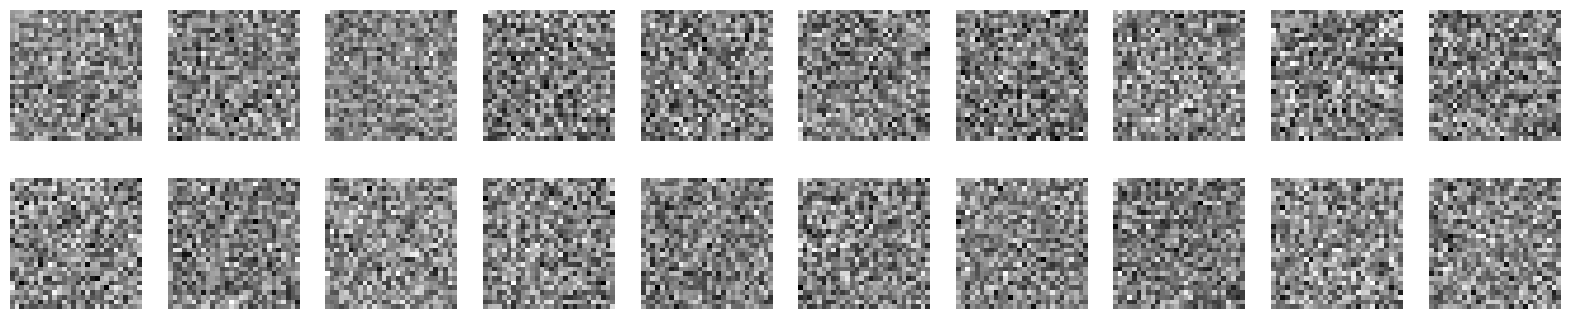

1000 [D loss: 0.6397] [G loss: 1.1596]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


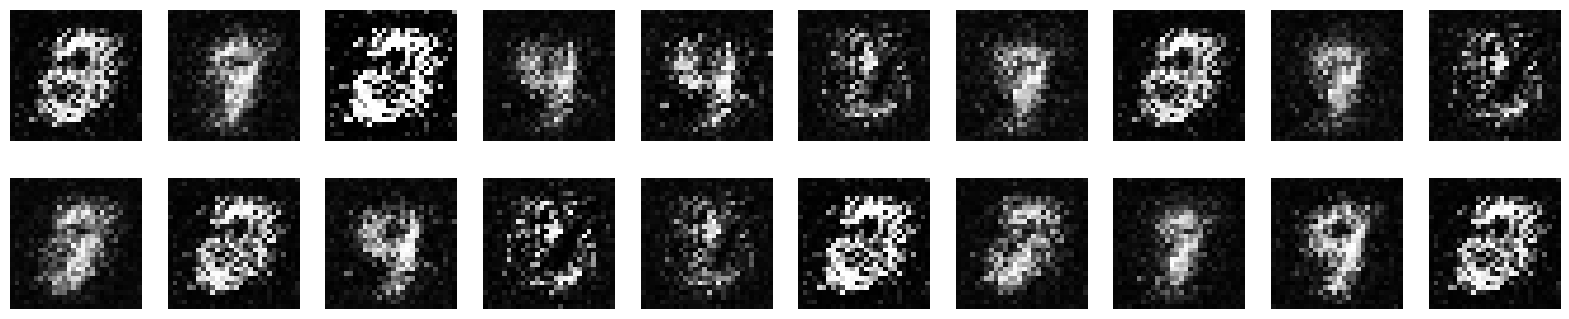

2000 [D loss: 0.6163] [G loss: 1.3154]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


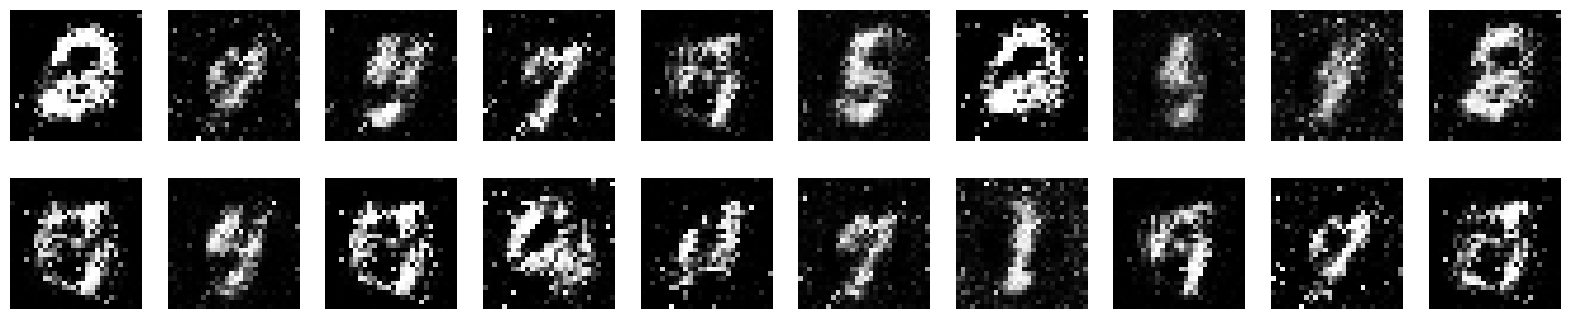

3000 [D loss: 0.5747] [G loss: 1.2841]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


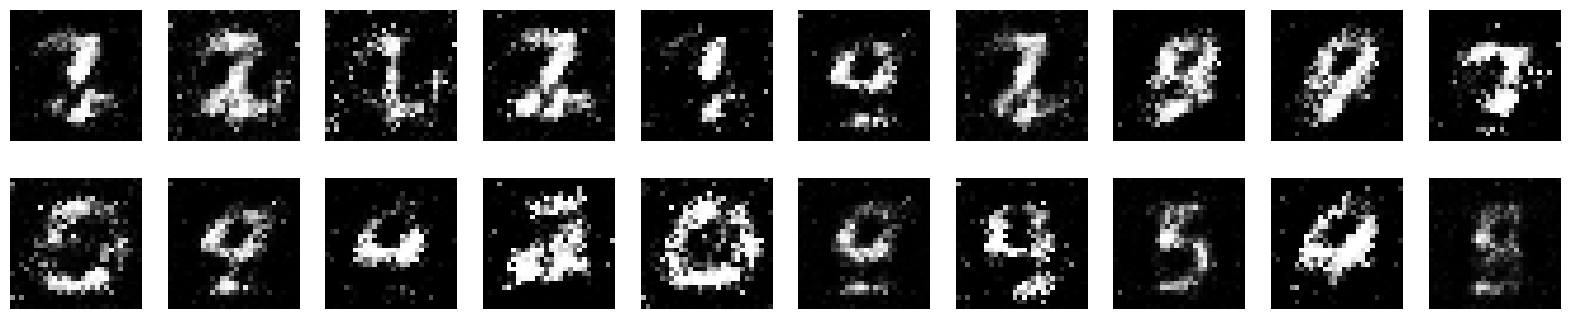

4000 [D loss: 0.5762] [G loss: 0.8664]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


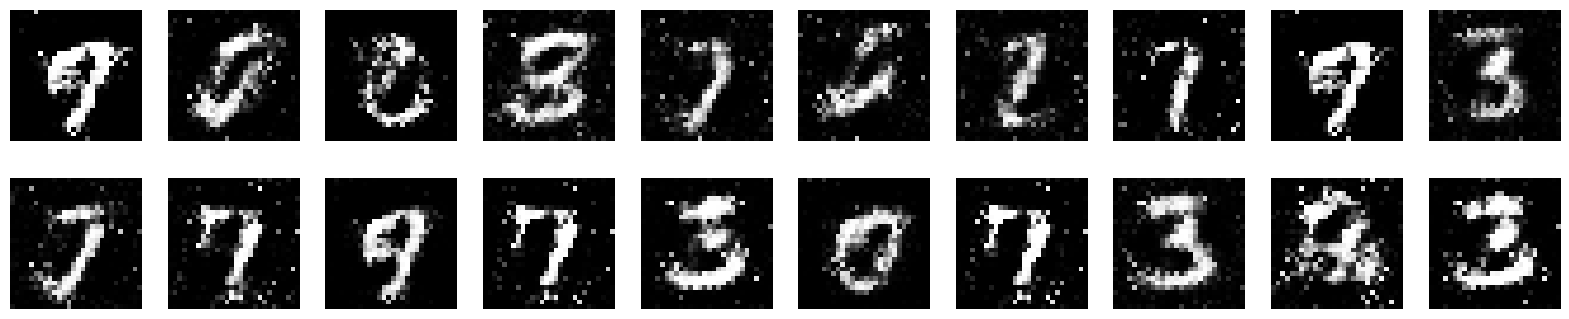

5000 [D loss: 0.5787] [G loss: 1.2786]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


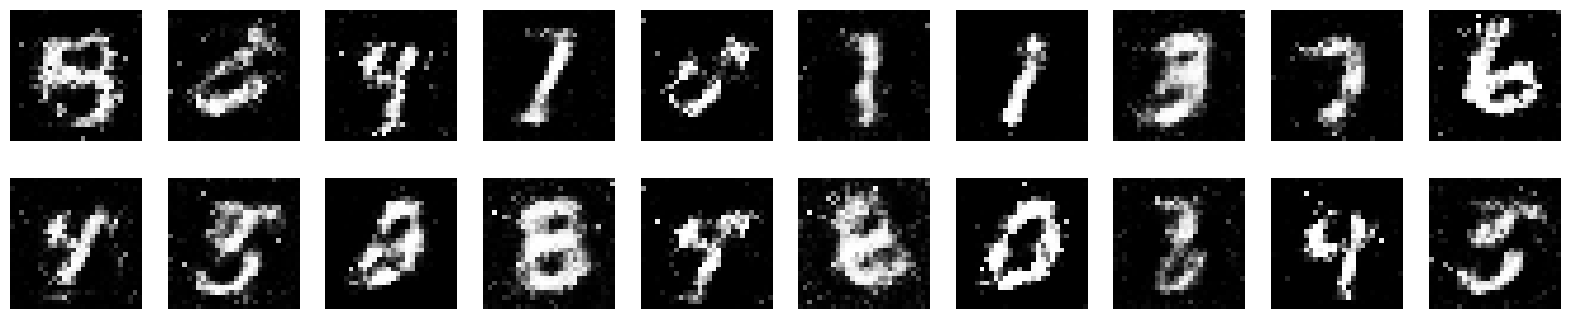

6000 [D loss: 0.6199] [G loss: 1.1573]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


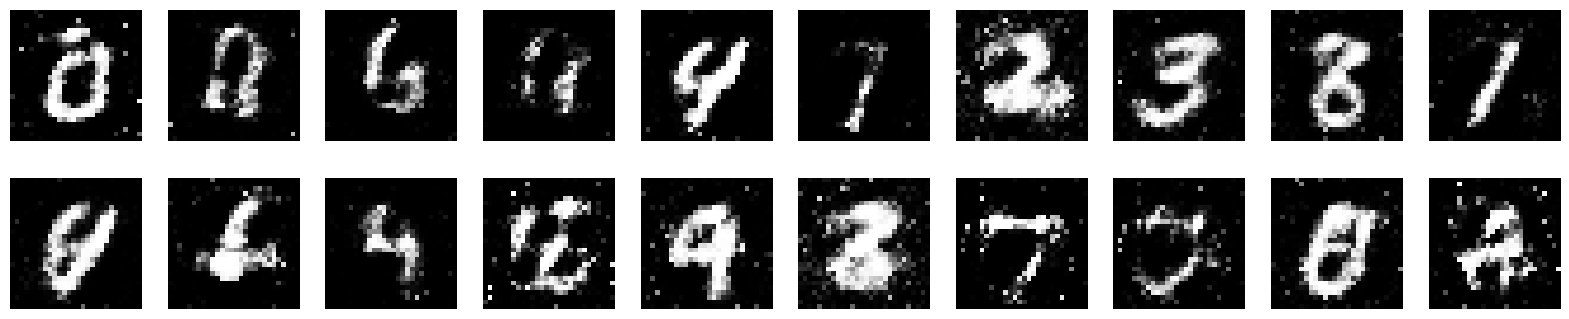

7000 [D loss: 0.6532] [G loss: 1.4401]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


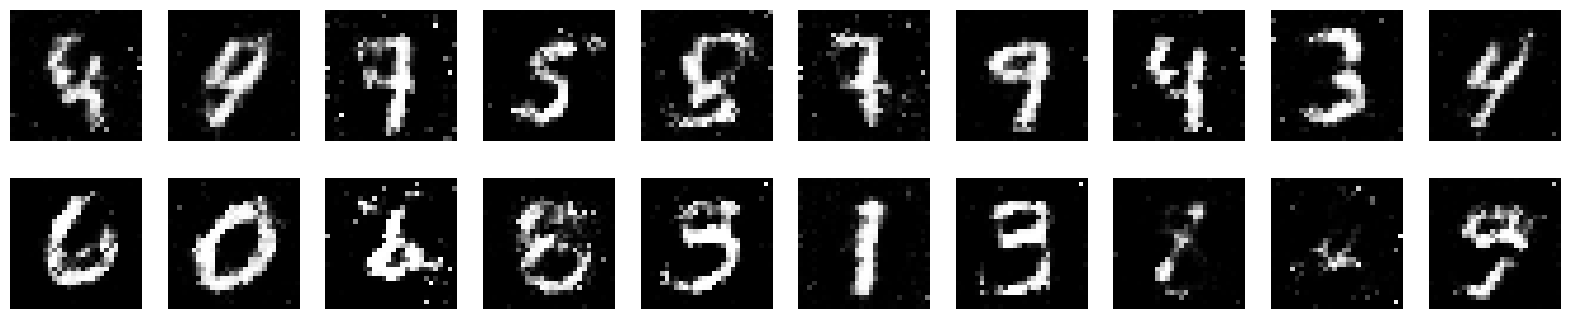

8000 [D loss: 0.6046] [G loss: 1.2876]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


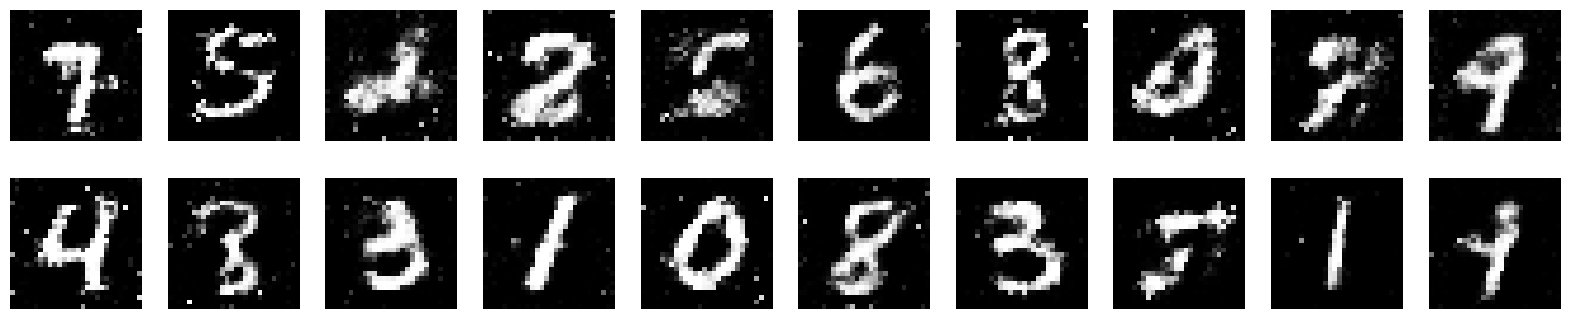

9000 [D loss: 0.5811] [G loss: 0.7351]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


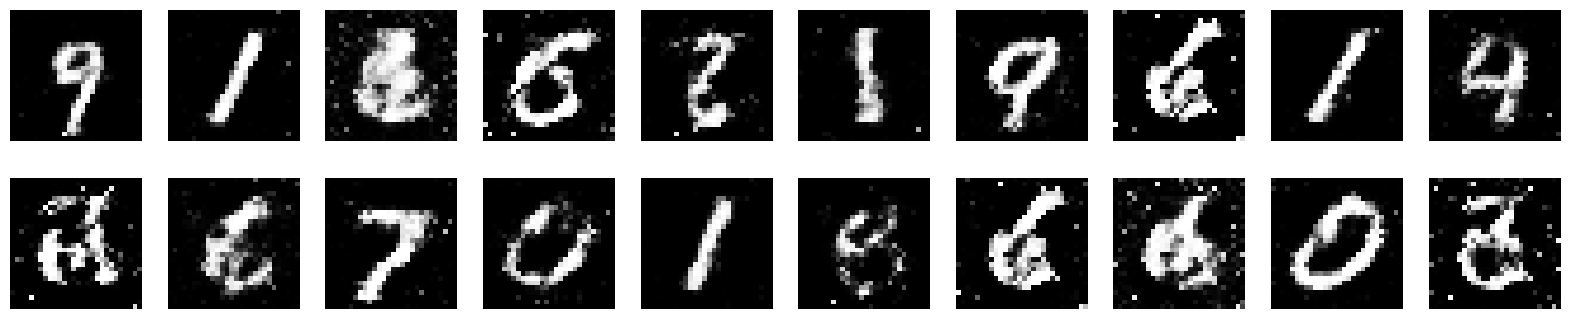

Training finished in 215.53s


In [12]:
import time

# CONFIGURATION
epochs = 10000
batch_size = 256 
print_interval = 1000

# 1. OPTIMIZED DATA LOADING
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
train_iterator = iter(dataset.repeat())

# 2. DEFINE OPTIMIZERS
d_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)
g_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)
cross_entropy = tf.keras.losses.BinaryCrossentropy()

# IMPORTANT: Unfreeze the discriminator!
# In custom loops, we control what gets trained by which tape we use.
discriminator.trainable = True 

# 3. COMPILED TRAINING STEP
@tf.function
def train_step(real_images):
    # Sample noise
    current_batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal([current_batch_size, 100])
    
    # --- Train Discriminator ---
    with tf.GradientTape() as d_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        d_loss_real = cross_entropy(tf.ones_like(real_output), real_output)
        d_loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
    
    # Calculate gradients for discriminator ONLY
    gradients_of_d = d_tape.gradient(d_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(gradients_of_d, discriminator.trainable_variables))

    # --- Train Generator ---
    with tf.GradientTape() as g_tape:
        noise = tf.random.normal([current_batch_size, 100])
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # Generator wants discriminator to output 1s
        g_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        
    # Calculate gradients for generator ONLY
    gradients_of_g = g_tape.gradient(g_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(gradients_of_g, generator.trainable_variables))
    
    return d_loss, g_loss

# 4. TRAINING LOOP
print(f"Starting optimized training on: {device}")
start_time = time.time()

for epoch in range(epochs):
    batch_imgs = next(train_iterator)
    d_loss, g_loss = train_step(batch_imgs)

    if epoch % print_interval == 0:
        print (f"{epoch} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")
        print_imgs()

print(f"Training finished in {time.time() - start_time:.2f}s")

### Exercise 1. GAN for CIFAR-10

Modify the code above to train on CIFAR-10.

In [ ]:
from keras.datasets import cifar10

epochs = 20000
batch_size = 128
save_interval = 2000

# Load the dataset
(X_train, _), (_, _) = cifar10.load_data()


#Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5


half_batch = int(batch_size / 2)

#Create lists for logging the losses
d_loss_logs_r = []
d_loss_logs_f = []
g_loss_logs = []

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half batch of images
    # ....

    

### Exercise 2 - try to use convolutional GAN

In [ ]:
##